# Analysis of Miao, Mendelson, and Wang pig data

In [138]:
import os
import tempfile

import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import torch
import skmisc
import anndata
import numpy as np
scvi.settings.seed = 0
import pandas as pd
import decoupler as dc

import time

Global seed set to 0


In [139]:
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats


# Convenience functions

In [150]:
def scVI_workflow(ad,samplename,sampledir,batch_key='SampleID',n_top_genes=2000,max_epochs=300):
    
    ad.write(f'{sampledir}/{samplename}.h5ad.gz',compression='gzip')
    print(ad.shape)
    try:
        sc.pp.highly_variable_genes(
            ad, flavor="seurat_v3", n_top_genes=n_top_genes, subset=True,batch_key=batch_key)
    except:
        sc.pp.highly_variable_genes(
            ad, flavor="seurat_v3", n_top_genes=n_top_genes, subset=True)
    print(ad.shape)
    scvi.model.SCVI.setup_anndata(ad, layer=None, batch_key=batch_key)
    model = scvi.model.SCVI(ad, n_latent=10, dispersion='gene', gene_likelihood='nb')
    model.train(max_epochs=max_epochs, accelerator='gpu', plan_kwargs={"lr": 5e-3}, check_val_every_n_epoch=10)
    train_elbo = model.history["elbo_train"][1:]
    test_elbo = model.history["elbo_validation"]
    print(ad.shape)
    ax = train_elbo.plot()
    test_elbo.plot(ax=ax)
    Z_hat = model.get_latent_representation()
    model_dir=f'/home/gennady/notebooks/gg2401_sn_13lgs/scvi/{samplename}'
    model.save(model_dir, save_anndata=False)

    SCVI_LATENT_KEY = "X_scVI"
    
    ad.obsm[SCVI_LATENT_KEY] = Z_hat
    sc.pp.neighbors(ad, use_rep=SCVI_LATENT_KEY, n_neighbors=25)
    t1=time.time()
    sc.tl.leiden(ad, key_added="leiden_scVI_02", resolution=0.2)
    sc.tl.leiden(ad, key_added="leiden_scVI_04", resolution=0.4)
    sc.tl.leiden(ad, key_added="leiden_scVI_06", resolution=0.6)
    sc.tl.leiden(ad, key_added="leiden_scVI_08", resolution=0.8)
    sc.tl.leiden(ad, key_added="leiden_scVI_10", resolution=1.0)
    sc.tl.leiden(ad, key_added="leiden_scVI_12", resolution=1.2)
    sc.tl.leiden(ad, key_added="leiden_scVI_14", resolution=1.4)
    t2=time.time()
    print('clustering time: '+str(t2-t1))

    sc.tl.umap(ad, min_dist=0.3)

    ad_allgenes=sc.read_h5ad(f'{sampledir}/{samplename}.h5ad.gz')
    print(ad.shape)
    for key in ad.obs.keys():
        ad_allgenes.obs[key]=ad.obs[key]
    for key in ad.uns.keys():
        ad_allgenes.uns[key]=ad.uns[key]
    for key in ad.obsm.keys():
        ad_allgenes.obsm[key]=ad.obsm[key]
    for key in ad.obsp.keys():
        ad_allgenes.obsp[key]=ad.obsp[key]
    ad=ad_allgenes.copy()
    print(ad.shape)
    ad.write(f'{sampledir}/{samplename}.h5ad.gz',compression='gzip')
    return ad

# Miao and Mendelson

In [141]:
ads=[sc.read_h5ad('/home/gennady/curation-results/miao/kb_out_nac/ad.h5ad.gz'),
     sc.read_h5ad('/home/gennady/curation-results/mendelson/kb_out_nac/ad.h5ad.gz')]

In [142]:
ad = anndata.concat(ads,axis=0)

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [143]:
ad.obs_names=ad.obs_names.str.split('-').str[0]

In [144]:
ad.obs_names_make_unique()

In [145]:
knees = []
samples = list(ad.obs['sample'].unique())
for sample in samples:
    knee = np.sort((np.array(ad[ad.obs['sample']==sample].X.sum(axis=1))).flatten())[::-1]
    knees.append(knee)


Text(0, 0.5, 'UMI counts')

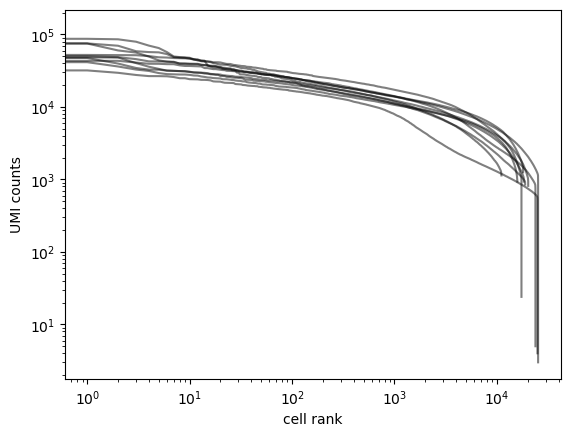

In [147]:
for i in range(len(samples)):
    plt.plot(range(len(knees[i])),knees[i],color='k',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('cell rank')
plt.ylabel('UMI counts')


In [148]:
ad.obs

sample    dataset   sex  condition region  \
AAACCCAAGAGTCGAC         TG_H       miao  male  Transgene     LV   
AAACCCAAGCACCCAC         TG_H       miao  male  Transgene     LV   
AAACCCAAGGATGCGT         TG_H       miao  male  Transgene     LV   
AAACCCAAGGCTATCT         TG_H       miao  male  Transgene     LV   
AAACCCAAGGGAGGAC         TG_H       miao  male  Transgene     LV   
...                       ...        ...   ...        ...    ...   
TTTGTTGGTAACGGTG  SRR32699345  mendelson  male        PAB     RA   
TTTGTTGGTCAAATCC  SRR32699345  mendelson  male        PAB     RA   
TTTGTTGGTCTCTCCA  SRR32699345  mendelson  male        PAB     RA   
TTTGTTGGTGCCTACG  SRR32699345  mendelson  male        PAB     RA   
TTTGTTGTCATCGCTC  SRR32699345  mendelson  male        PAB     RA   

                      suspension technology  
AAACCCAAGAGTCGAC  single-nucleus      10xv3  
AAACCCAAGCACCCAC  single-nucleus      10xv3  
AAACCCAAGGATGCGT  single-nucleus      10xv3  
AAACCCAAGGCTATCT  single-nucleus      10xv3  
AAACCCAAGGGAGGAC  single-nucleus      10xv3  
...                          ...        ...  
TTTGTTGGTAACGGTG  single-nucleus      10xv3  
TTTGTTGGTCAAATCC  single-nucleus      10xv3  
TTTGTTGGTCTCTCCA  single-nucleus      10xv3  
TTTGTTGGTGCCTACG  single-nucleus      10xv3  
TTTGTTGTCATCGCTC  single-nucleus      10xv3  

[193935 rows x 7 columns]

In [151]:
ad

AnnData object with n_obs × n_vars = 193935 × 35683
    obs: 'sample', 'dataset', 'sex', 'condition', 'region', 'suspension', 'technology'

In [ ]:
ad.write('/home/gennady/curation-results/heart_datasets/pig_heart/gg_250923_pig_heart_2.h5ad.gz',compression='gzip')

In [ ]:
ad_scVI=scVI_workflow(ad.copy(),'gg_250923_pig_heart_2','/home/gennady/curation-results/heart_datasets/pig_heart/scVI/',batch_key='sample',
                     n_top_genes=1000,max_epochs=150)

In [285]:
ad=sc.read_h5ad('/home/gennady/curation-results/heart_datasets/pig_heart/scVI/gg_250923_pig_heart_2.h5ad.gz')

In [286]:
ad

AnnData object with n_obs × n_vars = 193935 × 35683
    obs: 'sample', 'dataset', 'sex', 'condition', 'region', 'suspension', 'technology', '_scvi_batch', '_scvi_labels', 'leiden_scVI_02', 'leiden_scVI_04', 'leiden_scVI_06', 'leiden_scVI_08', 'leiden_scVI_10', 'leiden_scVI_12', 'leiden_scVI_14'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [287]:
ad.raw=ad.copy()
sc.pp.log1p(ad)

In [288]:
ad.obs

sample    dataset   sex  condition region  \
AAACCCAAGAGTCGAC         TG_H       miao  male  Transgene     LV   
AAACCCAAGCACCCAC         TG_H       miao  male  Transgene     LV   
AAACCCAAGGATGCGT         TG_H       miao  male  Transgene     LV   
AAACCCAAGGCTATCT         TG_H       miao  male  Transgene     LV   
AAACCCAAGGGAGGAC         TG_H       miao  male  Transgene     LV   
...                       ...        ...   ...        ...    ...   
TTTGTTGGTAACGGTG  SRR32699345  mendelson  male        PAB     RA   
TTTGTTGGTCAAATCC  SRR32699345  mendelson  male        PAB     RA   
TTTGTTGGTCTCTCCA  SRR32699345  mendelson  male        PAB     RA   
TTTGTTGGTGCCTACG  SRR32699345  mendelson  male        PAB     RA   
TTTGTTGTCATCGCTC  SRR32699345  mendelson  male        PAB     RA   

                      suspension technology  _scvi_batch  _scvi_labels  \
AAACCCAAGAGTCGAC  single-nucleus      10xv3            8             0   
AAACCCAAGCACCCAC  single-nucleus      10xv3            8             0   
AAACCCAAGGATGCGT  single-nucleus      10xv3            8             0   
AAACCCAAGGCTATCT  single-nucleus      10xv3            8             0   
AAACCCAAGGGAGGAC  single-nucleus      10xv3            8             0   
...                          ...        ...          ...           ...   
TTTGTTGGTAACGGTG  single-nucleus      10xv3            4             0   
TTTGTTGGTCAAATCC  single-nucleus      10xv3            4             0   
TTTGTTGGTCTCTCCA  single-nucleus      10xv3            4             0   
TTTGTTGGTGCCTACG  single-nucleus      10xv3            4             0   
TTTGTTGTCATCGCTC  single-nucleus      10xv3            4             0   

                 leiden_scVI_02 leiden_scVI_04 leiden_scVI_06 leiden_scVI_08  \
AAACCCAAGAGTCGAC              2              2              2              2   
AAACCCAAGCACCCAC              6              6              7              8   
AAACCCAAGGATGCGT              0              0              0              0   
AAACCCAAGGCTATCT              4              4              5              6   
AAACCCAAGGGAGGAC              2              2              2              2   
...                         ...            ...            ...            ...   
TTTGTTGGTAACGGTG              7              7              3              3   
TTTGTTGGTCAAATCC              0              0              3              3   
TTTGTTGGTCTCTCCA              0              0              0              0   
TTTGTTGGTGCCTACG              0              0              0              3   
TTTGTTGTCATCGCTC              8             14             16             15   

                 leiden_scVI_10 leiden_scVI_12 leiden_scVI_14  
AAACCCAAGAGTCGAC              8              8              8  
AAACCCAAGCACCCAC              9              9              9  
AAACCCAAGGATGCGT              0              1              1  
AAACCCAAGGCTATCT              6              6             11  
AAACCCAAGGGAGGAC              8              8              8  
...                         ...            ...            ...  
TTTGTTGGTAACGGTG              2             11             10  
TTTGTTGGTCAAATCC              2              3              5  
TTTGTTGGTCTCTCCA              0              1              1  
TTTGTTGGTGCCTACG              2              3              5  
TTTGTTGTCATCGCTC             17             19             20  

[193935 rows x 16 columns]

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


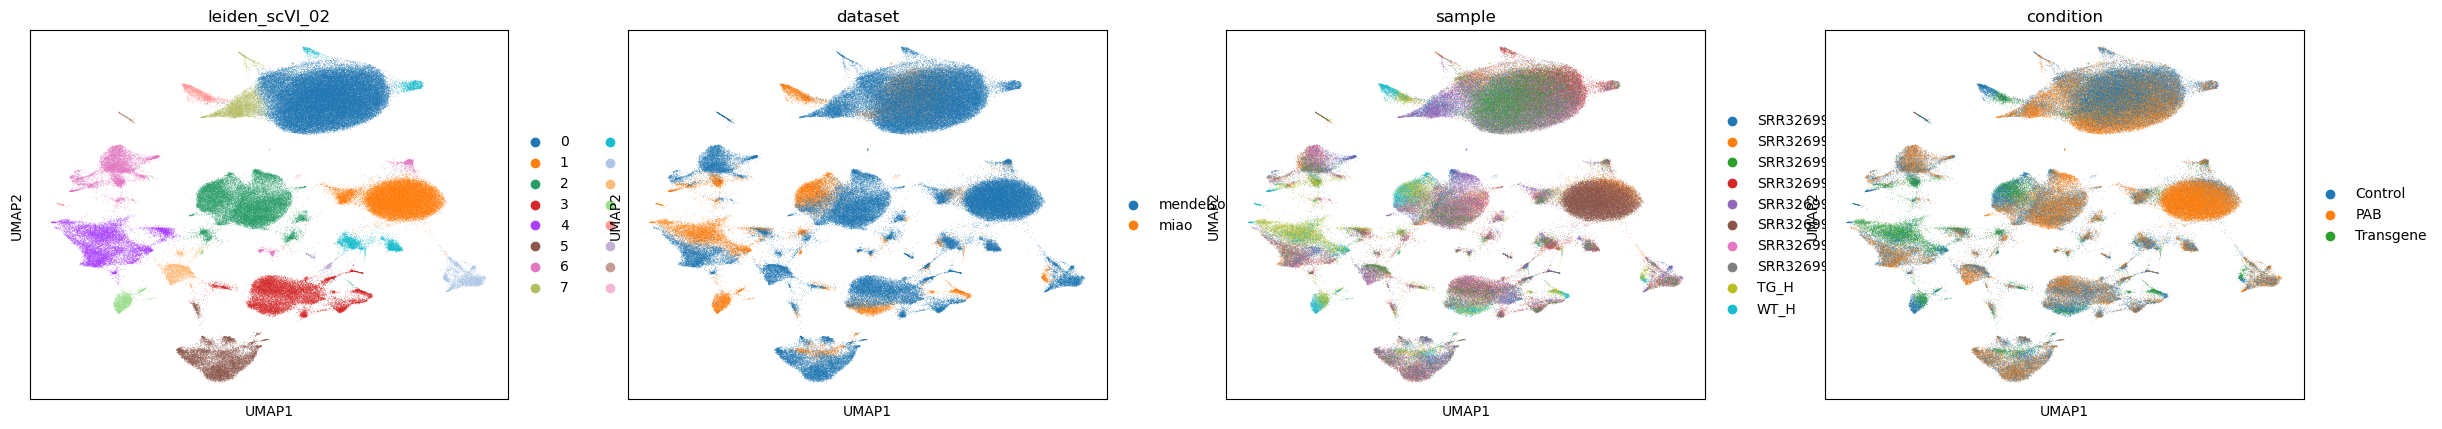

In [289]:
sc.pl.umap(ad,color=['leiden_scVI_02','dataset','sample','condition'])

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


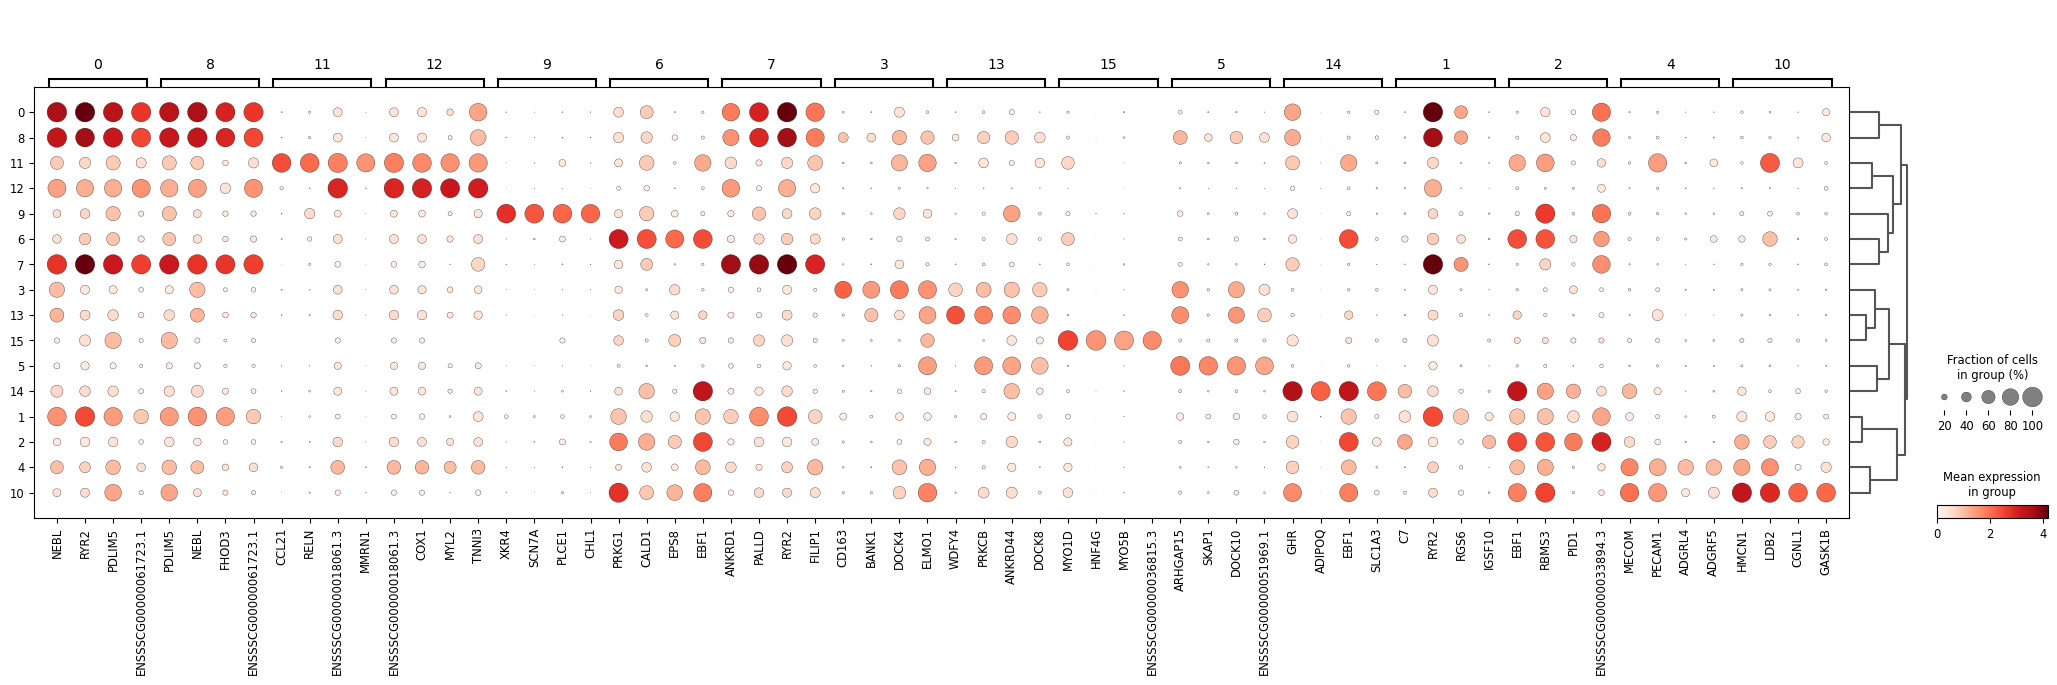

In [297]:
sc.tl.rank_genes_groups(ad, groupby='leiden_scVI_02', groups='all',reference='rest',use_raw=False,method='t-test')
sc.tl.dendrogram(ad,groupby='leiden_scVI_02',use_rep='X_scVI')
sc.pl.rank_genes_groups_dotplot(ad, n_genes=4,use_raw=False)


Evidently, cluster 9 consists of the neurons.

In [298]:
de=sc.get.rank_genes_groups_df(ad,group='9')
de.set_index('names',inplace=True)

In [299]:
de.loc[['PLP1','MPZ','SCN7A','GRIK2','NRXN1']]

scores  logfoldchanges          pvals      pvals_adj
names                                                          
PLP1    16.555012        8.295289   2.231436e-59   3.345560e-58
MPZ     24.343252        6.719245  2.845355e-121  7.888952e-120
SCN7A  146.571960        9.511028   0.000000e+00   0.000000e+00
GRIK2  114.293510        8.368761   0.000000e+00   0.000000e+00
NRXN1  125.532959        8.807532   0.000000e+00   0.000000e+00

In [304]:
de.loc[['LOC102165344']]

scores  logfoldchanges     pvals  pvals_adj
names                                                     
LOC102165344 -0.30605       -0.118678  0.759583   0.882257

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


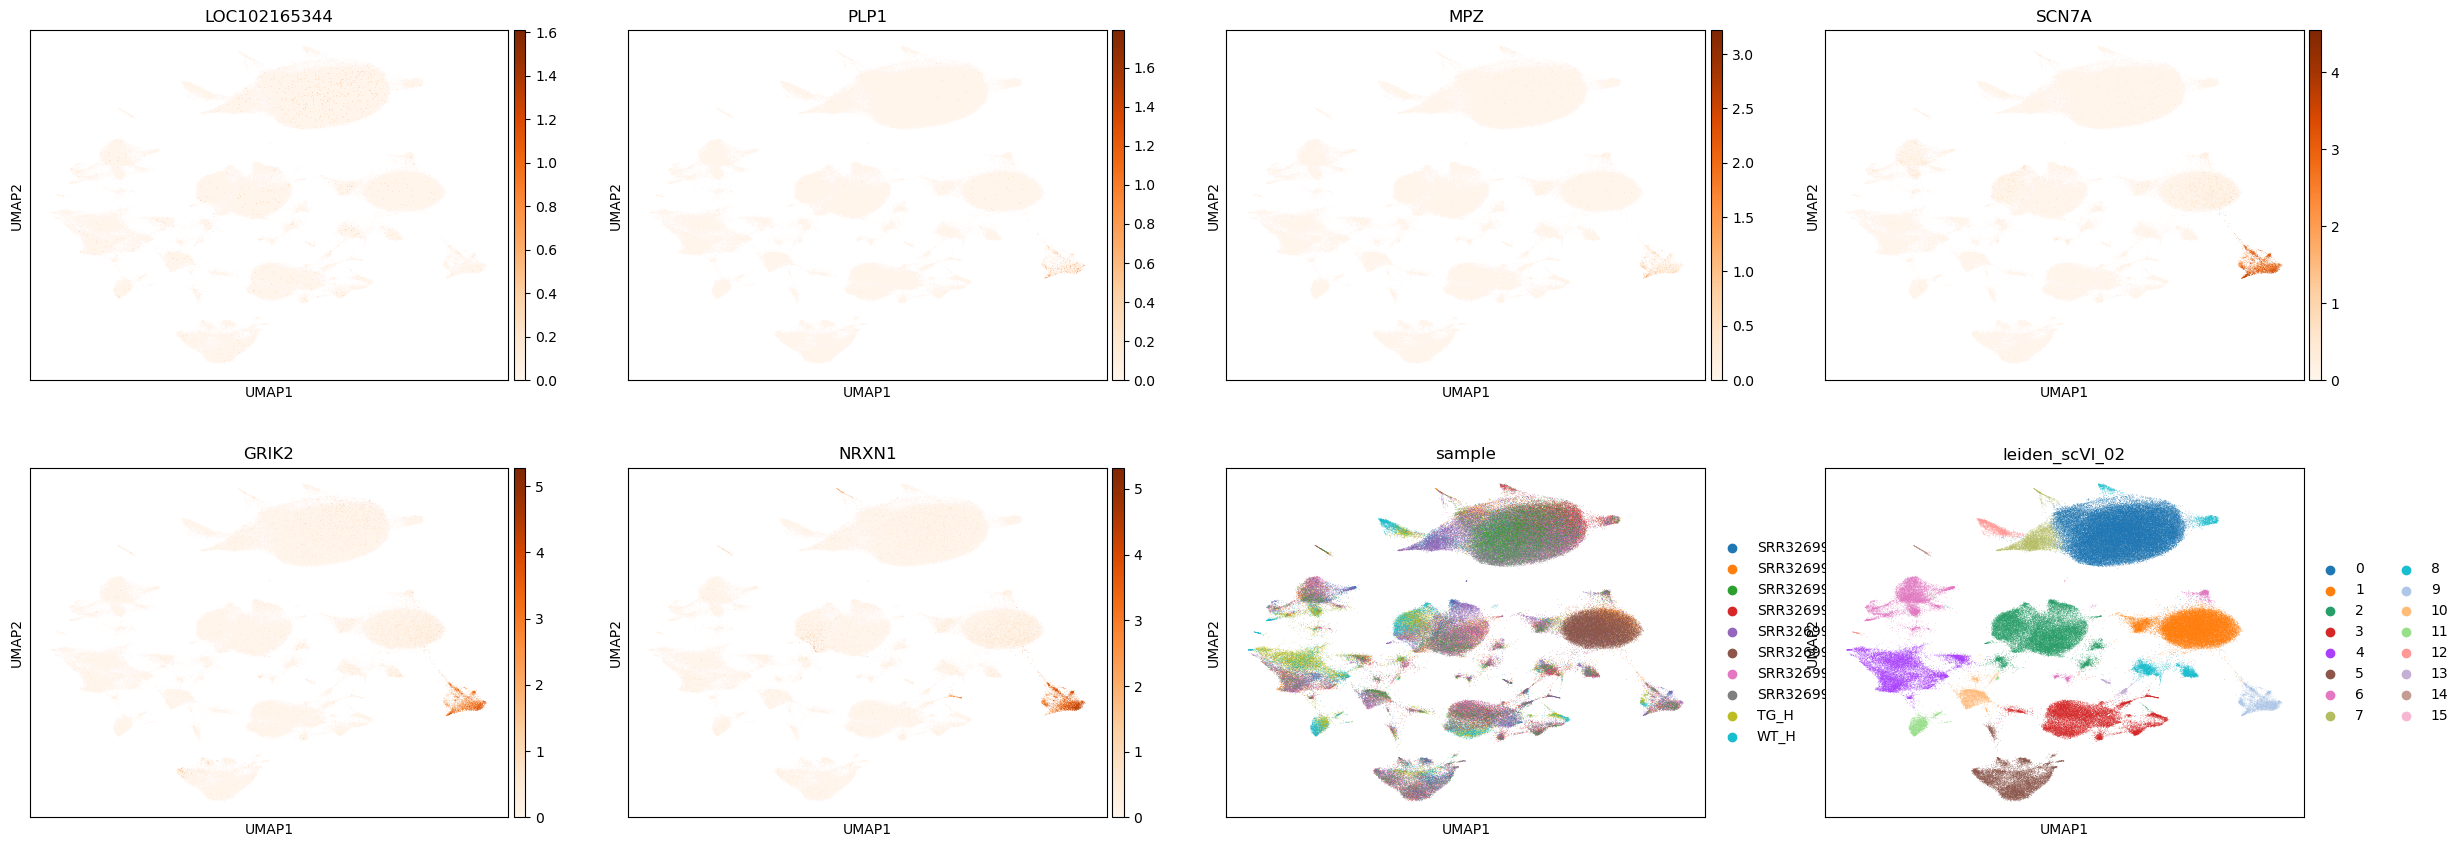

In [303]:
sc.pl.umap(ad,color=['LOC102165344','PLP1','MPZ','SCN7A','GRIK2','NRXN1','sample','leiden_scVI_02'],use_raw=False, cmap='Oranges')

In [88]:
ad.obs['log10_total_UMIs']=np.log10(ad.X.sum(1))

In [307]:
psbulk = dc.get_pseudobulk(ad,sample_col='sample',groups_col='leiden_scVI_02',use_raw=True,mode="sum",min_cells=0,min_counts=0)

Expression is low: on the order of 0.001-0.01 when it appears at all.

In [308]:
psbulk[psbulk.obs['leiden_scVI_02']=='9','LOC102165344'].X.toarray().squeeze().astype(int)

array([3, 2, 2, 1, 1, 0, 3, 1, 0, 0])

In [317]:
psbulk.obs.query('leiden_scVI_02=="9"').psbulk_n_cells.sum()

3587.0

In [316]:
psbulk.obs.query('leiden_scVI_02=="9"')

sample    dataset   sex  condition region      suspension  \
SRR32699341_9  SRR32699341  mendelson  male    Control     RA  single-nucleus   
SRR32699342_9  SRR32699342  mendelson  male    Control     RA  single-nucleus   
SRR32699343_9  SRR32699343  mendelson  male    Control     RA  single-nucleus   
SRR32699344_9  SRR32699344  mendelson  male    Control     RA  single-nucleus   
SRR32699345_9  SRR32699345  mendelson  male        PAB     RA  single-nucleus   
SRR32699346_9  SRR32699346  mendelson  male        PAB     RA  single-nucleus   
SRR32699347_9  SRR32699347  mendelson  male        PAB     RA  single-nucleus   
SRR32699348_9  SRR32699348  mendelson  male        PAB     RA  single-nucleus   
TG_H_9                TG_H       miao  male  Transgene     LV  single-nucleus   
WT_H_9                WT_H       miao  male    Control     LV  single-nucleus   

              technology _scvi_batch _scvi_labels leiden_scVI_02  \
SRR32699341_9      10xv3           0            0              9   
SRR32699342_9      10xv3           1            0              9   
SRR32699343_9      10xv3           2            0              9   
SRR32699344_9      10xv3           3            0              9   
SRR32699345_9      10xv3           4            0              9   
SRR32699346_9      10xv3           5            0              9   
SRR32699347_9      10xv3           6            0              9   
SRR32699348_9      10xv3           7            0              9   
TG_H_9             10xv3           8            0              9   
WT_H_9             10xv3           9            0              9   

               psbulk_n_cells  psbulk_counts  
SRR32699341_9           312.0      1546085.0  
SRR32699342_9           505.0      2047087.0  
SRR32699343_9           333.0      1933763.0  
SRR32699344_9           490.0      2195322.0  
SRR32699345_9           546.0      2203690.0  
SRR32699346_9            68.0       317548.0  
SRR32699347_9           542.0      2730514.0  
SRR32699348_9           331.0      1506646.0  
TG_H_9                  294.0       735832.0  
WT_H_9                  166.0       793558.0

In [315]:
psbulk[psbulk.obs['leiden_scVI_02']=='9','LOC102165344'].X.toarray().squeeze().astype(int)/psbulk.obs.query('leiden_scVI_02=="9"').psbulk_n_cells


SRR32699341_9    0.009615
SRR32699342_9    0.003960
SRR32699343_9    0.006006
SRR32699344_9    0.002041
SRR32699345_9    0.001832
SRR32699346_9    0.000000
SRR32699347_9    0.005535
SRR32699348_9    0.003021
TG_H_9           0.000000
WT_H_9           0.000000
Name: psbulk_n_cells, dtype: float64

# Wang et al. 

In [320]:
ad=sc.read_h5ad('/home/gennady/curation-results/wang_pig_atlas/kb_out_nac_dnbelab/ad.h5ad.gz')

In [322]:
ad.obs

sample         dataset   sex condition   region  \
AACACTCTCCAAGTAAGCGT  SRR17661076  wang_pig_atlas  male   Control  Unknown   
AACACTCTCCATGGAAGGCC  SRR17661076  wang_pig_atlas  male   Control  Unknown   
AACACTCTCCGATGAGAGGT  SRR17661076  wang_pig_atlas  male   Control  Unknown   
AACACTCTCCGTCACGTGCT  SRR17661076  wang_pig_atlas  male   Control  Unknown   
AACAGACGACAATCTACAAG  SRR17661076  wang_pig_atlas  male   Control  Unknown   
...                           ...             ...   ...       ...      ...   
TTGTCAGTGGACGACGTCCA  SRR17661080  wang_pig_atlas  male   Control  Unknown   
TTGTCGGTAAAATCAGTGGA  SRR17661080  wang_pig_atlas  male   Control  Unknown   
TTGTGGCATCCATGGACTCC  SRR17661080  wang_pig_atlas  male   Control  Unknown   
TTGTGGCATCCGATAAGCAC  SRR17661080  wang_pig_atlas  male   Control  Unknown   
TTGTGGCATCTATGAACAGC  SRR17661080  wang_pig_atlas  male   Control  Unknown   

                          suspension technology  
AACACTCTCCAAGTAAGCGT  single-nucleus  DNBelabC4  
AACACTCTCCATGGAAGGCC  single-nucleus  DNBelabC4  
AACACTCTCCGATGAGAGGT  single-nucleus  DNBelabC4  
AACACTCTCCGTCACGTGCT  single-nucleus  DNBelabC4  
AACAGACGACAATCTACAAG  single-nucleus  DNBelabC4  
...                              ...        ...  
TTGTCAGTGGACGACGTCCA  single-nucleus  DNBelabC4  
TTGTCGGTAAAATCAGTGGA  single-nucleus  DNBelabC4  
TTGTGGCATCCATGGACTCC  single-nucleus  DNBelabC4  
TTGTGGCATCCGATAAGCAC  single-nucleus  DNBelabC4  
TTGTGGCATCTATGAACAGC  single-nucleus  DNBelabC4  

[11145 rows x 7 columns]

In [323]:
knees = []
samples = list(ad.obs['sample'].unique())
for sample in samples:
    knee = np.sort((np.array(ad[ad.obs['sample']==sample].X.sum(axis=1))).flatten())[::-1]
    knees.append(knee)


Text(0, 0.5, 'UMI counts')

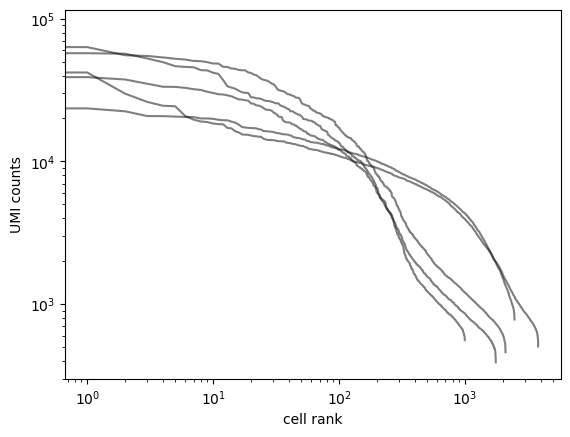

In [324]:
for i in range(len(samples)):
    plt.plot(range(len(knees[i])),knees[i],color='k',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('cell rank')
plt.ylabel('UMI counts')


In [325]:
ad.obs

sample         dataset   sex condition   region  \
AACACTCTCCAAGTAAGCGT  SRR17661076  wang_pig_atlas  male   Control  Unknown   
AACACTCTCCATGGAAGGCC  SRR17661076  wang_pig_atlas  male   Control  Unknown   
AACACTCTCCGATGAGAGGT  SRR17661076  wang_pig_atlas  male   Control  Unknown   
AACACTCTCCGTCACGTGCT  SRR17661076  wang_pig_atlas  male   Control  Unknown   
AACAGACGACAATCTACAAG  SRR17661076  wang_pig_atlas  male   Control  Unknown   
...                           ...             ...   ...       ...      ...   
TTGTCAGTGGACGACGTCCA  SRR17661080  wang_pig_atlas  male   Control  Unknown   
TTGTCGGTAAAATCAGTGGA  SRR17661080  wang_pig_atlas  male   Control  Unknown   
TTGTGGCATCCATGGACTCC  SRR17661080  wang_pig_atlas  male   Control  Unknown   
TTGTGGCATCCGATAAGCAC  SRR17661080  wang_pig_atlas  male   Control  Unknown   
TTGTGGCATCTATGAACAGC  SRR17661080  wang_pig_atlas  male   Control  Unknown   

                          suspension technology  
AACACTCTCCAAGTAAGCGT  single-nucleus  DNBelabC4  
AACACTCTCCATGGAAGGCC  single-nucleus  DNBelabC4  
AACACTCTCCGATGAGAGGT  single-nucleus  DNBelabC4  
AACACTCTCCGTCACGTGCT  single-nucleus  DNBelabC4  
AACAGACGACAATCTACAAG  single-nucleus  DNBelabC4  
...                              ...        ...  
TTGTCAGTGGACGACGTCCA  single-nucleus  DNBelabC4  
TTGTCGGTAAAATCAGTGGA  single-nucleus  DNBelabC4  
TTGTGGCATCCATGGACTCC  single-nucleus  DNBelabC4  
TTGTGGCATCCGATAAGCAC  single-nucleus  DNBelabC4  
TTGTGGCATCTATGAACAGC  single-nucleus  DNBelabC4  

[11145 rows x 7 columns]

In [326]:
ad.write('/home/gennady/curation-results/heart_datasets/pig_heart/gg_251202_pig_heart_wang.h5ad.gz',compression='gzip')

(11145, 35683)


/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scvi/model/_scvi.py:127: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(11145, 1000)
Epoch 150/150: 100%|██████████████████████████████████████████████████████████████████| 150/150 [02:05<00:00,  1.13it/s, v_num=1, train_loss_step=152, train_loss_epoch=160]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|██████████████████████████████████████████████████████████████████| 150/150 [02:05<00:00,  1.19it/s, v_num=1, train_loss_step=152, train_loss_epoch=160]
(11145, 1000)
clustering time: 13.599073648452759
(11145, 1000)
(11145, 35683)


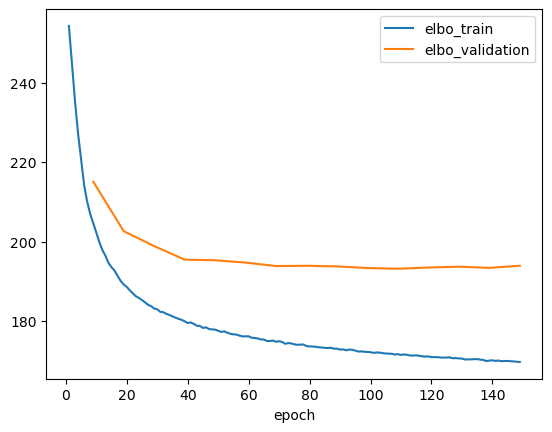

In [327]:
ad_scVI=scVI_workflow(ad.copy(),'gg_251202_pig_heart_wang','/home/gennady/curation-results/heart_datasets/pig_heart/scVI/',batch_key='sample',
                     n_top_genes=1000,max_epochs=150)

In [390]:
ad=sc.read_h5ad('/home/gennady/curation-results/heart_datasets/pig_heart/scVI/gg_251202_pig_heart_wang.h5ad.gz')

In [391]:
ad.raw=ad.copy()
sc.pp.log1p(ad)

In [392]:
ad.obs

sample         dataset   sex condition   region  \
AACACTCTCCAAGTAAGCGT  SRR17661076  wang_pig_atlas  male   Control  Unknown   
AACACTCTCCATGGAAGGCC  SRR17661076  wang_pig_atlas  male   Control  Unknown   
AACACTCTCCGATGAGAGGT  SRR17661076  wang_pig_atlas  male   Control  Unknown   
AACACTCTCCGTCACGTGCT  SRR17661076  wang_pig_atlas  male   Control  Unknown   
AACAGACGACAATCTACAAG  SRR17661076  wang_pig_atlas  male   Control  Unknown   
...                           ...             ...   ...       ...      ...   
TTGTCAGTGGACGACGTCCA  SRR17661080  wang_pig_atlas  male   Control  Unknown   
TTGTCGGTAAAATCAGTGGA  SRR17661080  wang_pig_atlas  male   Control  Unknown   
TTGTGGCATCCATGGACTCC  SRR17661080  wang_pig_atlas  male   Control  Unknown   
TTGTGGCATCCGATAAGCAC  SRR17661080  wang_pig_atlas  male   Control  Unknown   
TTGTGGCATCTATGAACAGC  SRR17661080  wang_pig_atlas  male   Control  Unknown   

                          suspension technology  _scvi_batch  _scvi_labels  \
AACACTCTCCAAGTAAGCGT  single-nucleus  DNBelabC4            0             0   
AACACTCTCCATGGAAGGCC  single-nucleus  DNBelabC4            0             0   
AACACTCTCCGATGAGAGGT  single-nucleus  DNBelabC4            0             0   
AACACTCTCCGTCACGTGCT  single-nucleus  DNBelabC4            0             0   
AACAGACGACAATCTACAAG  single-nucleus  DNBelabC4            0             0   
...                              ...        ...          ...           ...   
TTGTCAGTGGACGACGTCCA  single-nucleus  DNBelabC4            4             0   
TTGTCGGTAAAATCAGTGGA  single-nucleus  DNBelabC4            4             0   
TTGTGGCATCCATGGACTCC  single-nucleus  DNBelabC4            4             0   
TTGTGGCATCCGATAAGCAC  single-nucleus  DNBelabC4            4             0   
TTGTGGCATCTATGAACAGC  single-nucleus  DNBelabC4            4             0   

                     leiden_scVI_02 leiden_scVI_04 leiden_scVI_06  \
AACACTCTCCAAGTAAGCGT              0              0              0   
AACACTCTCCATGGAAGGCC              0              0              0   
AACACTCTCCGATGAGAGGT              0              0              0   
AACACTCTCCGTCACGTGCT              0              0              0   
AACAGACGACAATCTACAAG              0              2              2   
...                             ...            ...            ...   
TTGTCAGTGGACGACGTCCA              0              0              0   
TTGTCGGTAAAATCAGTGGA              1              1              1   
TTGTGGCATCCATGGACTCC              1              1              1   
TTGTGGCATCCGATAAGCAC              0              2              2   
TTGTGGCATCTATGAACAGC              1              1              1   

                     leiden_scVI_08 leiden_scVI_10 leiden_scVI_12  \
AACACTCTCCAAGTAAGCGT              1              1              5   
AACACTCTCCATGGAAGGCC              1              1              7   
AACACTCTCCGATGAGAGGT              2              7             10   
AACACTCTCCGTCACGTGCT              2              6             10   
AACAGACGACAATCTACAAG              3              2              1   
...                             ...            ...            ...   
TTGTCAGTGGACGACGTCCA              1              1              3   
TTGTCGGTAAAATCAGTGGA              0              0              4   
TTGTGGCATCCATGGACTCC              0              0              0   
TTGTGGCATCCGATAAGCAC              3              2              1   
TTGTGGCATCTATGAACAGC              0              0              0   

                     leiden_scVI_14  
AACACTCTCCAAGTAAGCGT              6  
AACACTCTCCATGGAAGGCC              8  
AACACTCTCCGATGAGAGGT             11  
AACACTCTCCGTCACGTGCT             11  
AACAGACGACAATCTACAAG              1  
...                             ...  
TTGTCAGTGGACGACGTCCA             14  
TTGTCGGTAAAATCAGTGGA              2  
TTGTGGCATCCATGGACTCC              0  
TTGTGGCATCCGATAAGCAC              1  
TTGTGGCATCTATGAACAGC              7  

[11145 rows x 16 columns]

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


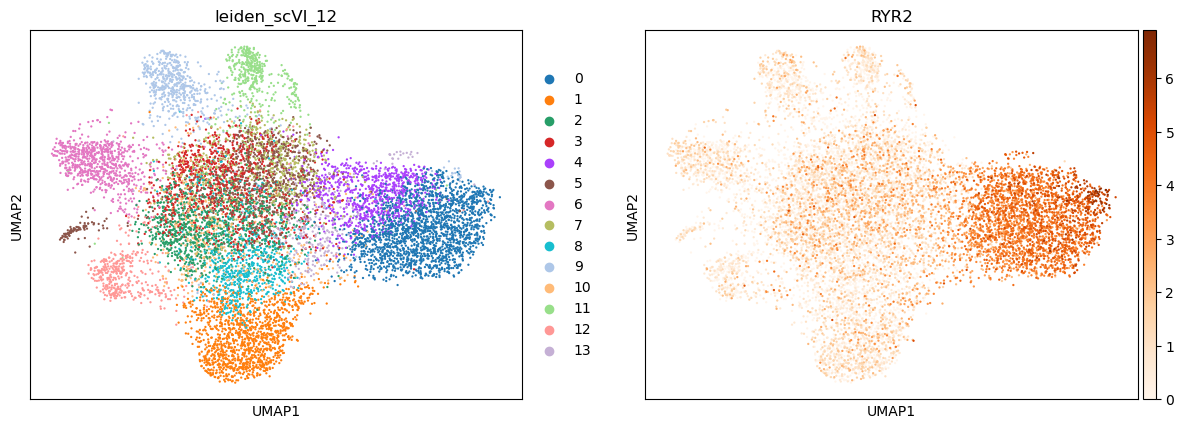

In [395]:
sc.pl.umap(ad,color=['leiden_scVI_12','RYR2'],cmap='Oranges',use_raw=False)

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


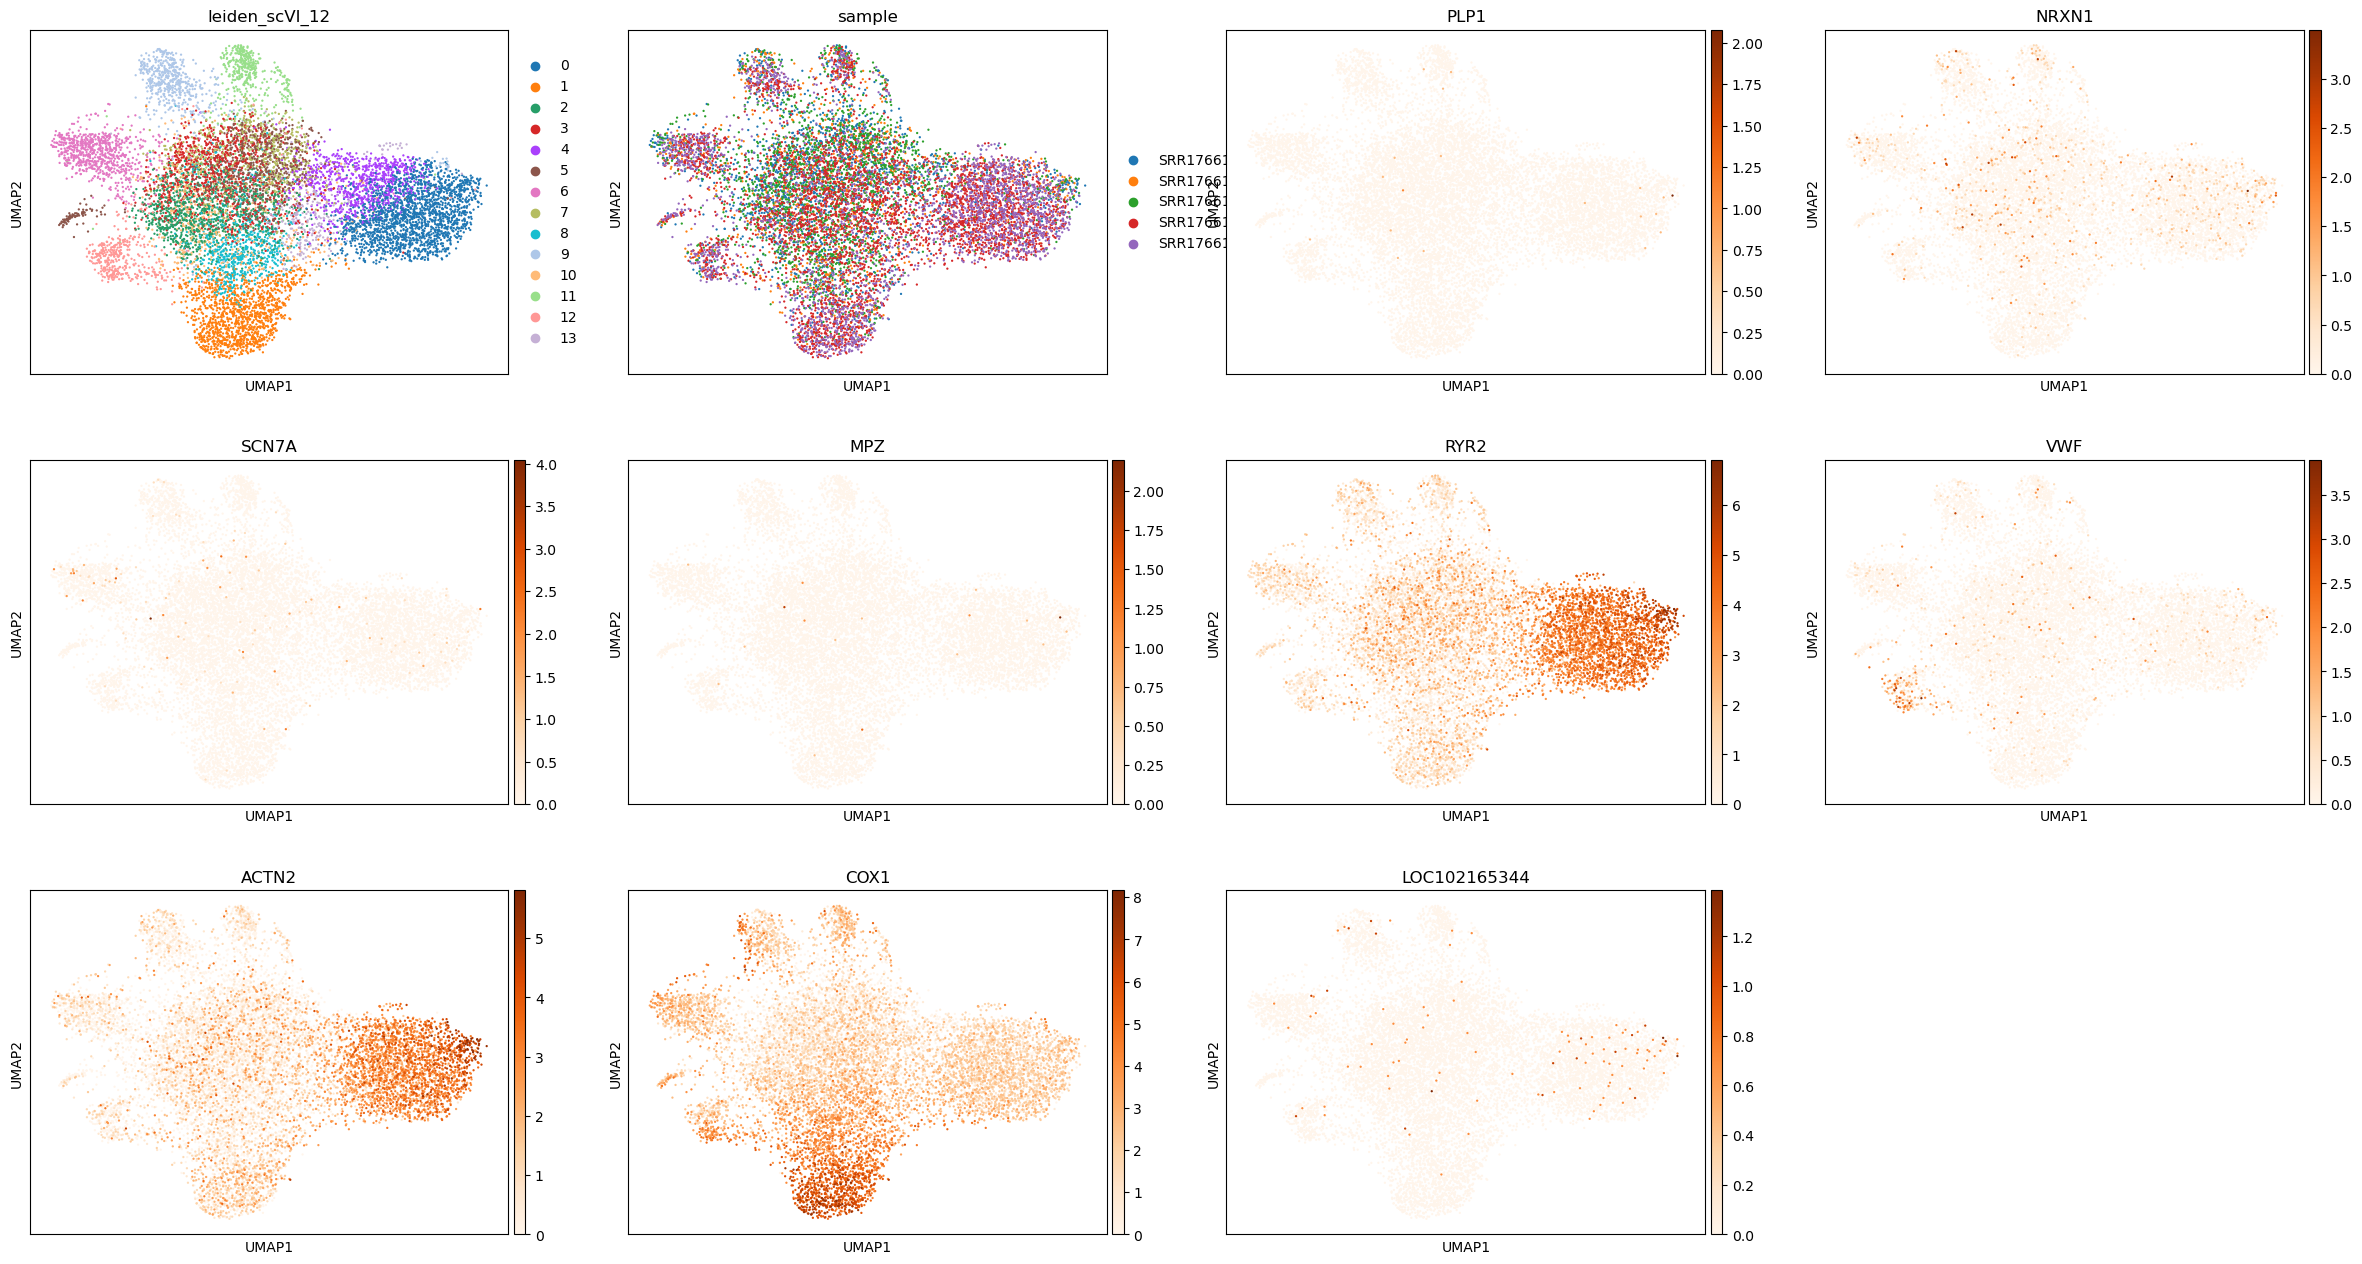

In [401]:
sc.pl.umap(ad,color=['leiden_scVI_12','sample','PLP1','NRXN1','SCN7A','MPZ','RYR2','VWF','ACTN2','COX1','LOC102165344'],cmap='Oranges',use_raw=False)

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


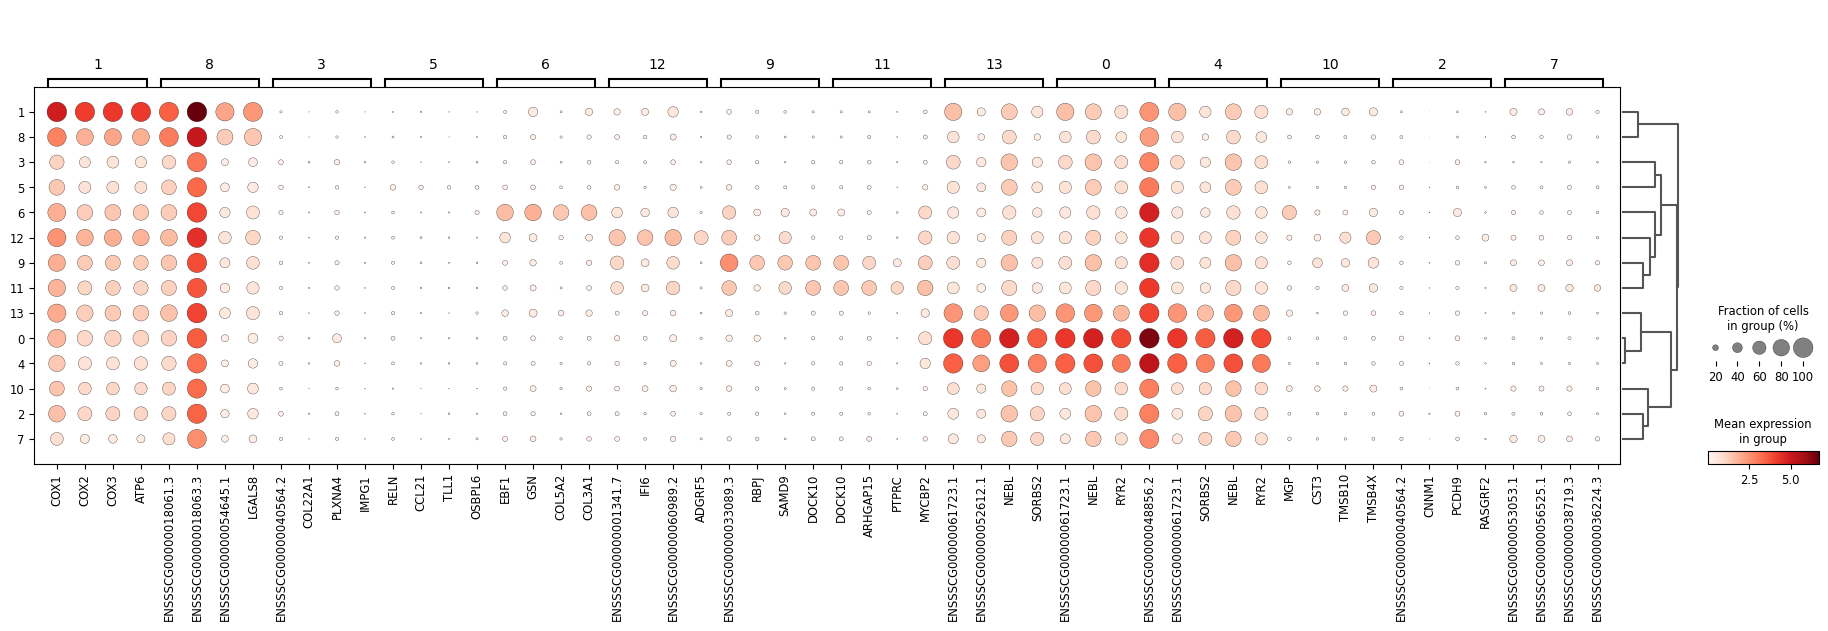

In [340]:
sc.tl.rank_genes_groups(ad, groupby='leiden_scVI_12', groups='all',reference='rest',use_raw=False,method='t-test')
sc.tl.dendrogram(ad,groupby='leiden_scVI_12',use_rep='X_scVI')
sc.pl.rank_genes_groups_dotplot(ad, n_genes=4,use_raw=False)


In [396]:
ad.obs['UMIs_per_barcode']=ad.raw.X.sum(1)
ad.obs['log10_UMIs_per_barcode']=np.log10(ad.obs['UMIs_per_barcode'])

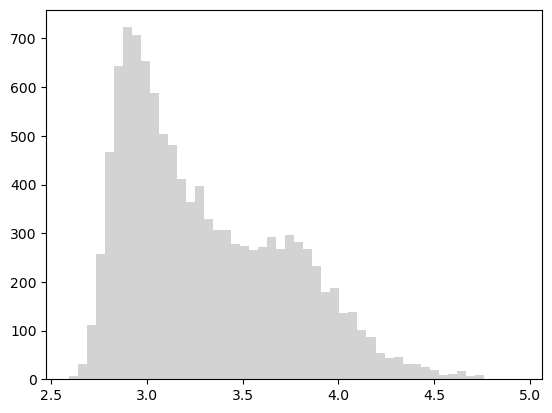

In [397]:
plt.hist(ad.obs['log10_UMIs_per_barcode'],50,facecolor='lightgray')
plt.show()

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


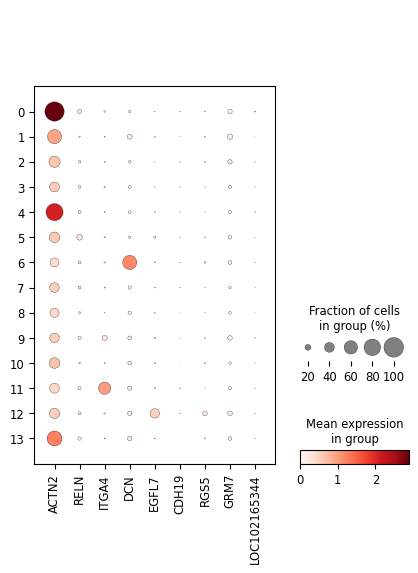

In [398]:
sc.pl.dotplot(ad,groupby='leiden_scVI_12',var_names=['ACTN2','RELN','ITGA4','DCN','EGFL7','CDH19','RGS5','GRM7','LOC102165344'],use_raw=False)

From these data, it does not appear that neurons were captured.


In [399]:
ad.raw[:,'LOC102165344'].X.sum()

124

In [400]:
(ad.raw[:,'LOC102165344'].X>0).sum()

102

## Female sc controls: realigned

In [378]:
ads = []
samples = ['SRR17661098','SRR17661099','SRR17661103','SRR17661104'] #adipose-S, adipose-V, lung, PBMC
for sample in samples:
    samp_dir=f'/home/gennady/curation-results/{dataset}/kb_out_nac_10x/{sample}/counts_filtered/'
    ad = sc.read_mtx(samp_dir+'cells_x_genes.total.mtx')
    bcs = np.loadtxt(samp_dir+'cells_x_genes.barcodes.txt',dtype=str)
    genes = np.loadtxt(samp_dir+'cells_x_genes.genes.names.txt',dtype=str)
    ad.var.index = genes
    ad.obs.index = bcs
    ad.obs['sample']=sample
    ads.append(ad)

In [379]:
[ad[:,'LOC102165344'].X.sum() for ad in ads]

[37.0, 34.0, 44036.0, 25642.0]

In [383]:
[ad[:,'ZFY'].X.sum() for ad in ads]

[9189.0, 9764.0, 8.0, 4.0]

In [384]:
[ad[:,'KDM5D'].X.sum() for ad in ads]

[1771.0, 1624.0, 3.0, 4.0]

In [385]:
[ad[:,'EIF1AY'].X.sum() for ad in ads]

[5203.0, 5264.0, 3.0, 5.0]

## Female sc controls: disclosed

In [386]:
samples=['GSM5824496_Pig-Adipose-S_','GSM5824497_Pig-Adipose-V_','GSM5824501_Pig-Lung_','GSM5824502_Pig-PBMC_']
ads=[sc.read_10x_mtx(path='/home/gennady/curation-results/wang_pig_atlas/geo',gex_only=False,prefix=x)
        for x in samples]

In [387]:
[ad[:,'ZFY'].X.sum() for ad in ads]

[1665.0, 1173.0, 1.0, 0.0]

In [388]:
[ad[:,'KDM5D'].X.sum() for ad in ads]

[188.0, 147.0, 0.0, 0.0]

In [389]:
[ad[:,'EIF1AY'].X.sum() for ad in ads]

[2053.0, 2061.0, 0.0, 0.0]

The adipose samples are  not from a female pig.